In [1]:
import subprocess
import os
import os.path
import numpy as np
from scipy.io import arff

OPENsmile installation details: I installed Opensmile in Ubuntu as explained in the book:
download tar.gz,
unzip,
`bash buildStandalone.sh` from within the folder opensmile-X.X.X, and
finally add path to .bashrc.

In [2]:
# Opensmile path
OPENSMILE_DIR = os.path.expanduser("~/openSMILE-2.1.0")
OPENSMILE_CONF = os.path.join('config', 'gemaps', 'GeMAPSv01a.conf')
OPENSMILE_CONF_PATH = os.path.join(OPENSMILE_DIR, OPENSMILE_CONF)

In [3]:
# IEMOCAP data path
IEMOCAP_PATH = "/media/vincent/enschede/IEMOCAP_full_release"
wave_files_path = os.path.join(IEMOCAP_PATH,"Session1/sentences/wav")
label_files_path = os.path.join(IEMOCAP_PATH,"Session1/dialog/EmoEvaluation")

In [4]:
# get content of directories
wavfiles = os.listdir(wave_files_path)
labfiles = os.listdir(label_files_path)

In [5]:
import os
wavfiles_list = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(wave_files_path)) for f in fn]
wavfiles = np.array(wavfiles_list)

In [6]:
def returnrealfiles(filenameslist):
    # Ignore wavfiles that start with .
    realfiles = []
    for i in range(len(filenameslist)):
        str_filename = str(filenameslist[i]).split("/")[-1]
        if (str_filename[0] != '.') & ((str_filename[-3:] == 'txt') | (str_filename[-3:] == 'wav')):
            realfiles.append(filenameslist[i])
    return realfiles;    

In [7]:
realwavfiles = returnrealfiles(wavfiles)
reallabfiles = returnrealfiles(labfiles)

## Ignore wavfiles that start with .
#realwavfiles = []
#for i in range(len(wavfiles)):
#    if str(wavfiles[i])[0] != '.':
#        realwavfiles.append(wavfiles[i])

In [8]:
# Let's focus on one wav and lab file for now
wave_filename = realwavfiles[0]
wave_fullpath =  os.path.join(wave_files_path,wave_filename )

In [9]:
wave_fullpath

'/media/vincent/enschede/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'

In [10]:
# find matching label file
# the wav files have longer names than the label files, so first remove the end:
wavenamepieces = wave_filename.split("/")[-1].split("_")
matchinglabfile = wavenamepieces[0] + '_' + wavenamepieces[1] + '.txt'
# check whether the matching label file truly exists:
matchinglabfile2 = [item for index, item in enumerate(reallabfiles) if matchinglabfile == item]
if len(matchinglabfile2) == 0:
    print("Error no matching label file found")
elif len(matchinglabfile2) > 1:
    print("Error two or more matching label files found")
matchinglabfile3 = ''.join(matchinglabfile2)
# create full path for labelfile:
lab_fullpath =  os.path.join(label_files_path, matchinglabfile3)

In [11]:
# define Open smile command
opensmile_conf = os.path.join(OPENSMILE_DIR,"config/MFCC12_0_D_A.conf")
# select .arff output format because it should be compatible with Scikit learn
features_file = "/media/vincent/enschede/" + wave_filename.split("/")[-1].replace('.wav', '') + ".csv"
command = "SMILExtract -I {input_file} -C {conf_file} -O {output_file}".format(
                                    input_file=wave_fullpath,
                                    conf_file=opensmile_conf,
                                    output_file=features_file)

In [12]:
# Run the Open smile command and save output
output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)

In [13]:
# arff format resulted in all kinds of problems:
# import arff
# data = arff.load(open(features_file,'r'))

## Explanation of how to move forward: https://github.com/danijel3/PyHTK/blob/master/python-test/test.py

In [14]:
import sys
sys.path.append('/home/vincent/enschede/explosmile/explosmile')
from HTKFeat import MFCC_HTK
from HTK import HCopy, HTKFile
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
htk = HTKFile()
htk.load(features_file)

In [16]:
htk.nSamples / 100


1.93

In [17]:
# object is a list of lists, now turn into numpy array:
htk_np_data = np.array(htk.data)

In [18]:
htk_np_data.shape

(193, 39)

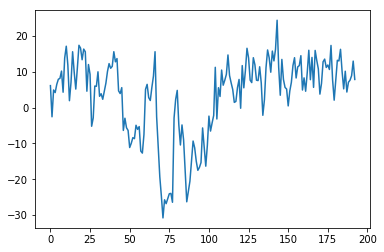

In [19]:
plt.plot(htk_np_data[:,4])
plt.show()

In [20]:
# look up annotation for that same file

In [21]:
features_file

'/media/vincent/enschede/Ses01F_impro01_F000.csv'

In [22]:
lab_fullpath

'/media/vincent/enschede/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt'

In [23]:
import pandas as pd

In [24]:
# get all labels for all utterances in this improvisation
labels = pd.read_table(lab_fullpath,header=0).iloc[0::8,:] # the summary is stored in every 8th row

In [25]:
# the format of the data needs to be tidied up a bit
# turn rownames into column
labels.index.name = 'newhead'
labels.reset_index(inplace=True)
# rename the columns that are now created
labels = labels.rename(columns={'level_0': '[START_TIME - END_TIME]', 'level_1': 'TURN_NAME', 'level_2': 'EMOTION'})
# split valence, activation, and dominance: 
labels[['V','A','D']] = labels['% [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D]'].str.split('\s',expand=True)
labels[['START_TIME','END_TIME']] = labels['[START_TIME - END_TIME]'].str.split(' - ',expand=True)
labels = labels.drop(['% [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D]','[START_TIME - END_TIME]'], axis=1)
# remove unwanted characters
for colnam in ['V','A','D', 'START_TIME','END_TIME']:
    labels[colnam] = labels[colnam].map(lambda x: x.lstrip('[,').rstrip('],'))    

In [26]:
labels.head()

,TURN_NAME,EMOTION,V,A,D,START_TIME,END_TIME
0,Ses01F_impro01_F000,neu,2.5000,2.5000,2.5000,6.2901,8.2357
1,Ses01F_impro01_F001,neu,2.5000,2.5000,2.5000,10.0100,11.3925
2,Ses01F_impro01_F002,neu,2.5000,2.5000,2.5000,14.8872,18.0175
3,Ses01F_impro01_F003,xxx,2.5000,3.0000,3.0000,19.2900,20.7875
4,Ses01F_impro01_F004,xxx,2.5000,3.0000,2.5000,21.3257,24.7400


In [27]:
# find the row for which the TURN_NAME matches the wav features file
TURNNAMEwav = features_file.split("/")[-1].split(".cs")[0]
b = [index for index, item in enumerate(labels['TURN_NAME']) if TURNNAMEwav == item][0]
# extract label for this utterance
label = labels['EMOTION'][b]


In [28]:
# Explore SVM in scikit learn

## Example of how to apply SVM on the X and y later on: http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html, which clarifies that X should be a Numpy array with shape (n_samples, n_features)